# Multi-parameter calibration of the OpenCL RAMP model using ABC

### Parameter definitions
The OpenCL RAMP model creates a synthetic population and simulates the movements of individuals between various locations (home, work, school, shops). If an individual is infected then they impart an infection risk on to the locations that they visit. The severity of this infection risk is determined by whether the individual is presymptomatic, asymptomatic or symptomatic (the **individual's hazard rating**). The locations in the model thus come to have an infection risk, based upon how many infected individuals from each infection status have visited. When susceptible individuals without the disease visit these locations their risk of being infected is determined by the location's infection risk, alongside the transmission hazard associated with that kind of location (the location's hazard rating). An additional hazard rating, the current risk beta, is used to control the general transmissability of the disease (?) 

### Parameter calibration
The <ins>location</ins> and <ins>individual</ins> hazards, and the current risk beta rating must be calibrated to find the values which best reproduce real life observations. Here, the parameter values are calibrated once using historical data and Approximate Bayesian Computation (ABC). 

Prior distributions for each parameter are defined and then ABC approximates the likelihoods of different parameter values by running the model a large number of times. Each time parameter values are drawn randomly from the prior distributions, and the parameter values from the simulations with results closest to the observations are kept. A fitness function is used to assess the similarity of model results to observations. In this case, the Euclidean difference between the observed number of cases per week and the simulated number of cases per week is calculated. 

In this script, the predictive model is calibrated once. The model is ran using ABC for 105 days, with two populations.  


### Parameter priors
ABC requires prior distributions to be specified for the parameters.

<ins>Location hazards</ins> 
 - `Home` (transmission hazard associated with being with an infected individual at home)
     - <i>Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0. </i>
 - `Retail` (transmission hazard associated with being with an infected individual in a shop)
     - <i> Uniform between 0 and 1 </i>
 - `PrimarySchool` (transmission hazard associated with being with an infected individual at primary school)
     - <i> Uniform between 0 and 1 </i> 
 - `SecondarySchool` (transmission hazard associated with being with an infected individual at secondary school)
     - <i> Uniform between 0 and 1 </i> 
 - `Work` (transmission hazard associated with being with an infected individual at work)
     - <i> Uniform between 0 and 1 </i> 
 
<ins> Individual hazards</ins> 
 - `asymptomatic` (transmission hazard associated with asymptomatic individuals)  
      - <i> This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). </i>
 - `presymptomatic` (transmission hazard associated with presymptomatic individuals)  
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ? </i>
 - `symptomatic` (transmission hazard associated with symptomatic individuals)   
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ?)</i>       


<ins> Other hazards</ins> 
- `current_risk_beta`  

<!-- To adapt an ABM to allow it to be optimised in response to data emerging in real time. This would mean performing dynamic calibration (i.e. re calibrating at every model time step) using ABC. -->

<!-- At the moment, however, such predictive ABMs are generally calibrated once, using historical data to adjust their more flexible parameters such that the model predicts present and past conditions well. The models are then allowed to roll forward in time, independent of the world, to make a prediction. As the systems modelled are usually complex, it is likely that over longer time periods such models diverge from realistic estimates. Even over shorter time periods there is little done to check model performance, let alone constrain it. -->




## Import modules

In [55]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

## Setup

Read parameters

In [56]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "


Open snapshot (i.e. an already-initialised model)

In [57]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

#### Read in observation data

In [58]:
# # Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
cases_devon_daily['Date'] =  pd.to_datetime(cases_devon_daily['Date'])

# # Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()

cases_devon_daily.insert(0, 'Day', range(0,len(cases_devon_daily)))
cases_devon_daily = cases_devon_daily.rename(columns ={'OriginalCases': 'Cases'})
cases_devon_daily = cases_devon_daily.drop(['Date', 'Cases'], axis=1)
# cases_devon_daily= cases_devon_daily.rename(columns ={'CumulativeCases': 'Cases'})
cases_devon_daily

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_aggregated_from_daily_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()
cases_devon_weekly.head()

,Date,OriginalCases,CumulativeCases
0,2020-03-22,768.188763,768.188763
1,2020-03-29,1417.566351,2185.755114
2,2020-04-05,2062.734952,4248.490065
3,2020-04-12,2467.541220,6716.031286
4,2020-04-19,2428.151380,9144.182665


### Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model, i.e. using the parameter values specified in the parameters file

In [59]:
# ### Run default (manually calibrated) model
# This shows what happens with the 'default' (manually calibrated) model
ITERATIONS = 105  # Number of iterations to run for (must be multiple of 7)
NUM_SEED_DAYS =7   # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# Think x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS,
    repetitions = REPETITIONS,
    observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,
    opencl_dir = OPENCL_DIR,
    snapshot_filepath = SNAPSHOT_FILEPATH,
    num_seed_days = NUM_SEED_DAYS
)

In [60]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# What does repetitions mean, if only end up with one set of results??

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [03:09<00:00, 37.80s/it]


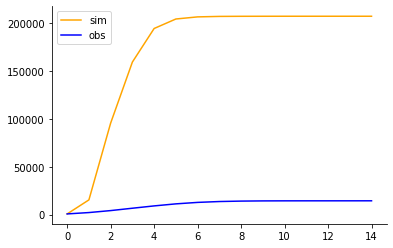

In [61]:
# Check the model returns the observations correctly
# i.e. that theyre the same length
np.array_equal(obs0, cases_devon_daily.loc[:len(sim0)-1,"CumulativeCases"])

# Print the fitness and plot the different disease counts
# print(f"fitness: {fitness0}")
# print(pd.DataFrame({"sim":sim0, "real_obs1":obs0}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, sim0, label="sim", color="orange")
ax.plot(x, obs0, label="obs", color="blue")
ax.legend()


## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/). Full details in [abc-1.ipynb](abc-1.ipynb)

### Fitness

Need a `distance` function to calculate error. This one gets the observations and simulation data from a dataframe and calls a function that returns the Euclidean distance (L2 norm) calculate 

In [62]:
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

### Priors

Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


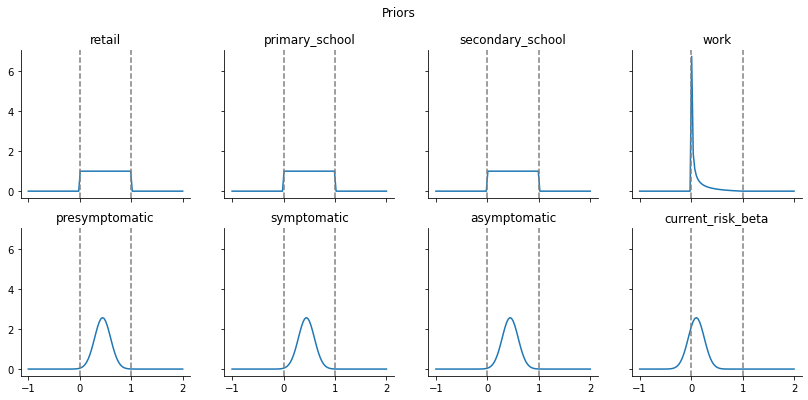

In [65]:
# Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_)
# The following should all be constant (overiding whatever is in the default.yml parameters file)
OpenCLRunner.set_constants( {"home": 1.0 })

# FYI this is how to represent with discrete discributions and one possible value (hack that didn't work):
# home_rv, current_risk_beta_rv = ( pyabc.RV('rv_discrete', values=([0.03], [1.0])) for _ in range(2) )
current_risk_beta_rv = pyabc.RV("norm", 0.1, 0.155)

# Now the random variables:
# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook).
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {
    "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv, 
    "current_risk_beta":current_risk_beta_rv}


fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

# ax.legend()
# fig.tight_layout()
fig.suptitle("Priors")
fig.show()



In [74]:
# Most priors can be passed straight to the distribution, except for 'asymptomatic' because it's normal
# so needs to be decorated to stay above 0
priors = pyabc.Distribution(
    #home = home_rv,
    retail = retail_rv,
    primary_school = primary_school_rv,
    secondary_school = secondary_school_rv,
    work = work_rv,
    presymptomatic = pyabc.LowerBoundDecorator(presymptomatic_rv, 0.0),
    symptomatic = pyabc.LowerBoundDecorator(symptomatic_rv, 0.0),
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0)
    )


### Initialise the ABC algorithm.

In [75]:
# ### Initialise the ABC algorithm.
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    # distance_function = OpenCLWrapper.distance,
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    #transition=transition,  # Define how to transition from one population to the next
    )

Define observations

In [77]:
# 'Real' cumulative cases: 
y_observed = cases_devon_weekly.loc[:(ITERATIONS/7)-1, "CumulativeCases"].values

Where to store results


In [78]:
db_path = ("sqlite:///" + os.path.join(".", "abc-2.db"))

In [79]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

ABC.History INFO: Start <ABCSMC id=32, start_time=2022-02-16 12:15:41>


### Run ABC

In [3]:
# with open('105days.pkl', 'rb') as f:
#     history = pickle.load(f)

In [71]:
# sys.path.append('..')
# # from ArbitraryDistribution import ArbitraryDistribution
# dist_df, dist_w = history.get_distribution(m=0, t=history.max_t)
# if 'current_risk_beta' in dist_df.columns:
#     dist_df = dist_df.drop(columns = 'current_risk_beta')
# priors = ArbitraryDistribution(history)
# priors.copy()


In [ ]:
history = abc.run(max_nr_populations=2) 
# history = None
# fname = "./abc-2.pkl"
# # history = abc.run(max_nr_populations=2) 
# if LOAD_PICKLES and os.path.isfile(fname):
#     print("loading pickles")
#     with open( fname, "rb" ) as f:
#         history = pickle.load(f)
# else:
#     history = abc.run(max_nr_populations=2) 
#     # The history object only works if it has the associated database too ('abc-1.db')
#     with open( fname, "wb" ) as f:
#         pickle.dump( history, f)

ABC INFO: Calibration sample t = -1.
Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.90s/it]


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.20s/it]
ABC INFO: t: 0, eps: 4.86094481e+05.


1260184.5834735439
1065111.4092055277
631438.420545997
364568.34718553646
42552.92307176667
254274.4055598327
1057530.3168836306
526575.7212614726
877408.9327056648
453017.8931080935
774428.6902090278
160104.96704196098
100836.50590719937
1469102.1468307707
338595.21654251986
98121.21394615332
97911.63511222355
195629.52906697756
121586.61818572186
599688.3950040911
1162610.7930675552
1002015.8460332509
516548.1388588243
381436.18412099965
227874.9747792351
1376451.9814280588
400038.98701939976
1200061.5952482892
536190.4451401262
1223013.2090861457
1173546.0390180897
476319.83587361843
525425.09703012
339379.74013771553
625826.2904698445
82035.68374364935
1426812.2232491488
99559.52863961128
482990.53740807355
1124490.4902968083
52021.033924251446
92068.62917336008
51353.56687445718
1048320.1218288623
1553610.3678517353
42499.73505786114
746385.5869871213
723605.8968243647
250303.36860590414
813845.8716191184
160245.0777538083
672648.5798317177
751874.6001750065
545555.8732321813
3215

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.56s/it]


266541.19345622003


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.24s/it]


847335.63769679


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.72s/it]


332028.6823377431


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.27s/it]


693063.8590307939


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.38s/it]


1248661.8289447168


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.54s/it]


151097.466242472


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00, 10.00s/it]


789879.4894775097


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.47s/it]


657468.0657162591


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.31s/it]


239685.43677136244


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.10s/it]


194269.39500626514


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.02s/it]


83483.41571519877


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.34s/it]


1350242.4539404917


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.41s/it]


297650.47908643185


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.31s/it]


5737.115458629122


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.07s/it]


595638.5223002243


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.92s/it]


447197.67346859997


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.44s/it]


972245.4719587305


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.23s/it]


1277935.2822546016


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.93s/it]


1119534.682250025


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.13s/it]


557818.3191759737


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.70s/it]


169794.8420048855


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.03s/it]


1328362.1520684669


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.29s/it]


1055149.5867993277


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.61s/it]


1329137.0810518574


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.47s/it]


871451.8066586265


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.33s/it]


36808.21303030058


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.68s/it]


105145.69682132099


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.19s/it]


98969.69159473717


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.33s/it]


198519.65326324955


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.44s/it]


298501.7174138134


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.02s/it]


26601.97767433382


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.46s/it]


236979.99517057362


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.28s/it]


941839.9236972525


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.73s/it]


31460.520545840558


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.22s/it]


270661.3906456743


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.25s/it]


854825.7294691288


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.98s/it]


564711.7810705184


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.38s/it]


814248.9499113233


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.47s/it]


404564.58654496586


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.05s/it]


131161.02555472267


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.10s/it]


1030611.2967810286


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.86s/it]


11976.878360931767


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.65s/it]


759438.5008481445


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.53s/it]


458259.61128581746


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.27s/it]


1322095.877381732


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.32s/it]


1219521.7978832964


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.87s/it]


124844.99802223277


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.87s/it]


436537.7860322294


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.19s/it]


421111.7417967367


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.44s/it]


131217.22740111494


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.29s/it]


1125729.6569556694


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.10s/it]


1074514.443968419


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.76s/it]


568009.4152180495


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.81s/it]


1780698.4234703272


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.82s/it]


1217301.4464086706


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.78s/it]


105291.75049968378


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.30s/it]


111501.0495837822


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.73s/it]


260709.34530338383


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.30s/it]


10391.181590290424


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.92s/it]


196950.81164453202


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.35s/it]


1721049.1751983091


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.56s/it]


176766.83099749958


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.45s/it]


485770.49661260354


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.76s/it]


1232095.8591430474


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.62s/it]


863084.6992346602


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.91s/it]


605393.4601132603


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.84s/it]


877463.1795140851


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.66s/it]


108253.33781404934


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.61s/it]


1420219.919695231


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.62s/it]


173212.07399988818


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.46s/it]


304295.04829377634


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.37s/it]


1332839.3883563292


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.21s/it]


692311.3779920252


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.96s/it]


1374017.2231211357


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.16s/it]


230329.65670341064


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.88s/it]


59752.06568286116


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.96s/it]


120880.37909666881


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.60s/it]


909388.159972059


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.89s/it]


1129398.6052200058


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00, 10.00s/it]


601782.7276527392


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.93s/it]


236698.54069020107


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.80s/it]


1659193.4283951179


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.79s/it]


1053946.3876308769


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.08s/it]


243184.04557378037


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.96s/it]


326592.15900067176


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.61s/it]


632063.958250239


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.08s/it]


818154.349874546


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.39s/it]


1213642.8399463384


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.19s/it]


83195.91930625854


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.62s/it]


166158.000377656


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.00s/it]


190661.92990620068


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.86s/it]


38137.09579677675


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


134722.91436754182


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.94s/it]


718346.6518591552


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.27s/it]


362462.0250023979


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.87s/it]


42944.0079941436


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.66s/it]


1335061.7977780458


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.32s/it]


210766.78708519312


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.93s/it]


1031731.0720918074


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.06s/it]


429054.6385197706


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.61s/it]


208778.04366386513


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.62s/it]


715769.1983010769


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.56s/it]


172238.592382329


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.87s/it]


428148.6269945845


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.40s/it]


676458.332440089


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.39s/it]


378997.80141695694


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:12<00:00, 14.40s/it]


215527.05038789663


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:12<00:00, 14.48s/it]


1491245.308162841


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:24<00:00, 16.87s/it]


717500.8921503564


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:17<00:00, 15.44s/it]


1298642.1790414203


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:23<00:00, 16.65s/it]


49763.97801948134


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:19<00:00, 15.89s/it]


84641.02917896476


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.93s/it]


18337.065250329928


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.13s/it]


53163.45264036015


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.76s/it]


154507.149851895


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.93s/it]


1020637.1798198882


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.73s/it]


614463.73266654


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.59s/it]


607491.1060597972


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.91s/it]


390137.534663072


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.93s/it]


753130.6738243869


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.37s/it]


775733.5873483217


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.07s/it]


366248.6823424097


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.41s/it]


663719.0708489951


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.89s/it]


93370.83457041382


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.05s/it]


456076.6305533299


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.79s/it]


83035.53598415748


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.90s/it]


1210740.6444398968


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


627944.1291394489


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.80s/it]


1020665.2680074061


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.27s/it]


226747.71645577112


Running models:  60%|████████████████████████████████████████▊                           | 3/5 [00:26<00:17,  8.96s/it]

### Algorithm diagnostics

In [ ]:
# _, arr_ax = plt.subplots(2, 2)

# pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
# pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
# #pyabc.visualization.plot_credible_intervals(
# #    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
# #    show_mean=True, show_kde_max_1d=True,
# #    refval={'mean': 2.5}, 
# #    arr_ax=arr_ax[1][0])
# pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

# plt.gcf().set_size_inches((12, 8))
# plt.gcf().tight_layout()

#### Plot the marginal posteriors  
The estimates of the optimal values for each parameter individually

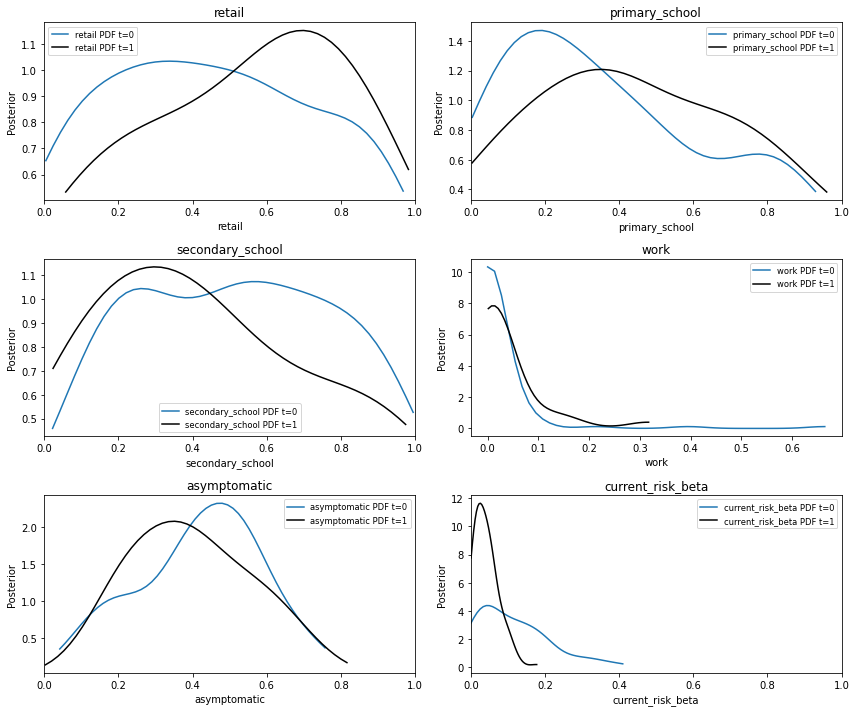

In [44]:
# fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,10))
fig, axes = plt.subplots(3,2, figsize=(12,10))
#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        ) 
        if param!="work":
            ax.set_xlim(0,1)
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

In [148]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


Now look at the 2D correlations (_I'm not sure how to read this_)

### Analyse the posterior

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [46]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,primary_school,retail,secondary_school,work,weight
0,385,0.357709,0.050188,0.396544,0.058017,0.451099,0.001305,0.113187
1,426,0.466915,0.008228,0.750158,0.744050,0.060936,0.004178,0.090340
2,368,0.591302,0.021926,0.641883,0.923727,0.277831,0.005954,0.079905
3,378,0.226114,0.008281,0.901598,0.620915,0.974587,0.007095,0.070833
4,396,0.227214,0.048787,0.361715,0.817526,0.254377,0.001360,0.048354
...,...,...,...,...,...,...,...,...
95,362,0.003296,0.112668,0.581966,0.759055,0.230467,0.029092,0.000967
96,401,0.110204,0.045629,0.297847,0.644962,0.237152,0.042018,0.000752
97,390,0.037137,0.068838,0.722717,0.091646,0.081382,0.061242,0.000731
98,366,0.151454,0.015742,0.118239,0.509856,0.848102,0.058886,0.000568


This code shows how to calculate the fitness associated with each particle (not the correct way to draw from the posterior so not especially useful).

Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:

 - Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).
 
 - Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.


#### ABC Posterior (A) - Sample

Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [73]:
N_samples = 50
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

## Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
#df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
#sample_idx = np.random.choice(
#            a=range(history.get_nr_particles_per_population().values[-1]),
#            size=N_samples, replace=True, p=w)
#samples = df.iloc[sample_idx] 

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    param_values = {param: sample[str(param)] for param in priors}

    # Run the model
    # _fitness = fitness (comparison between sim and obs)
    # _sim =  model_weekly_cumulative_infections
    # _obs = obs_weekly_cumulative_infections
    # _out_params = 
    # _summaries = 
    (_fitness, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    # print(f"Fitness: {_fitness}. Sample: {sample}")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")
    
# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])

    
# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")
pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.93s/it]


Fitness: 134840.89675797077.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.87s/it]


Fitness: 43385.20884039032.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.54s/it]


Fitness: 455318.63972130365.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.79s/it]


Fitness: 281507.44334171625.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


Fitness: 32683.316803657373.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.12s/it]


Fitness: 136461.44901092703.
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.13s/it]


Fitness: 52839.212890166775.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.01s/it]


Fitness: 212000.13238659198.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.03s/it]


Fitness: 38607.94806840568.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.05s/it]


Fitness: 27829.139459327398.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.90s/it]


Fitness: 776403.2626059805.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.09s/it]


Fitness: 92415.7232602063.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.14s/it]


Fitness: 107890.49790925998.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.13s/it]


Fitness: 362156.93617689866.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.91s/it]


Fitness: 44015.089996664545.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.04s/it]


Fitness: 105016.14846831931.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.84s/it]


Fitness: 487372.83758751716.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.96s/it]


Fitness: 221118.67119766408.
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


Fitness: 349963.6479729006.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.37s/it]


Fitness: 28049.19425667845.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


Fitness: 10497.060090988169.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


Fitness: 132994.82563103864.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.43s/it]


Fitness: 24968.33827183913.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.09s/it]


Fitness: 34685.41302482559.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


Fitness: 182730.78889021513.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.86s/it]


Fitness: 21488.419128756083.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.88s/it]


Fitness: 31301.161785487846.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.74s/it]


Fitness: 16093.740934478925.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.75s/it]


Fitness: 30478.232263501162.
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.69s/it]


Fitness: 44256.21885258285.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.06s/it]


Fitness: 301830.62367799575.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.27s/it]


Fitness: 31435.403702180647.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.10s/it]


Fitness: 533509.3362314958.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.20s/it]


Fitness: 40066.336342740724.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.13s/it]


Fitness: 283846.19757391233.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.64s/it]


Fitness: 8009.177772775338.
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]


Fitness: 43441.20130241242.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.17s/it]


Fitness: 243118.97268518014.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.17s/it]


Fitness: 216031.85772898208.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.18s/it]


Fitness: 131169.97058005884.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.42s/it]


Fitness: 54623.275570532394.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.08s/it]


Fitness: 76809.93052695082.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


Fitness: 173529.40782272743.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.85s/it]


Fitness: 34777.929358096546.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.65s/it]


Fitness: 13758.881679461509.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.85s/it]


Fitness: 5929.8723944261355.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.59s/it]


Fitness: 229746.59234398286.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.86s/it]


Fitness: 24416.215989298842.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


Fitness: 457919.4521095874.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.01s/it]

Fitness: 29058.336783537212.
Finished sampling. Ignored 53 negative samples.


Plot the individual results for each sample

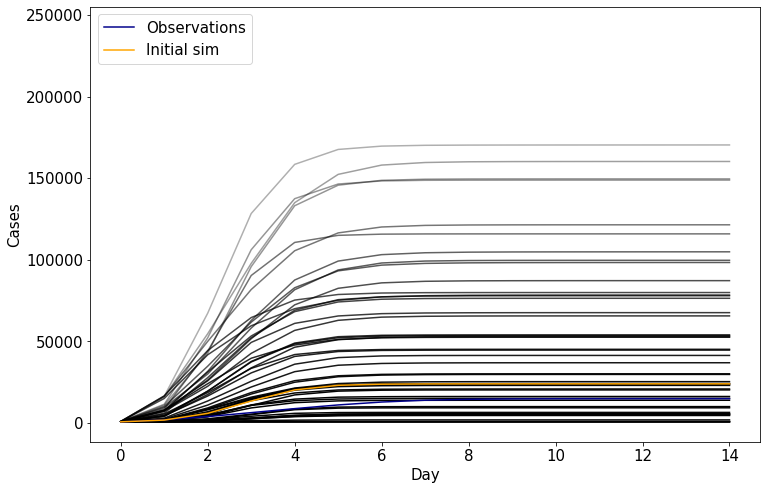

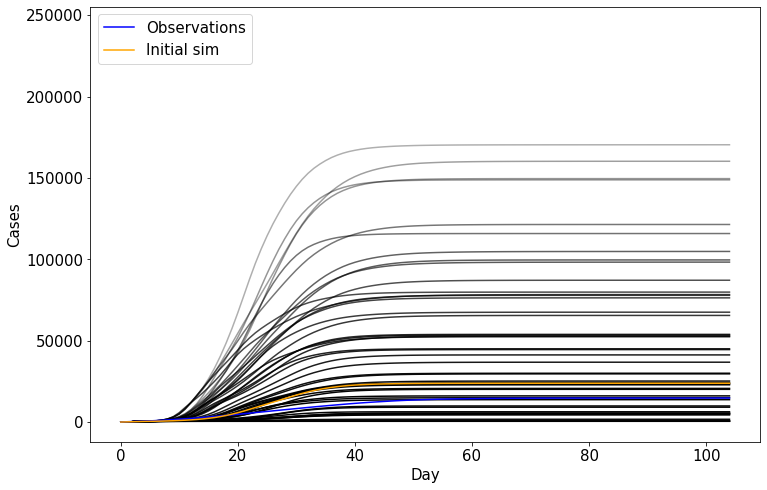

In [78]:
# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))

############## PLOT WEEKLY DATA
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax.plot(x, sim_l[i],
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - fitness_norm[i]  # (1-x because high fitness is bad)
            )
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
# Plot observations
ax.plot(x, obs_l[0], label="Observations", color="darkblue")
# Plot result from manually calibrated model
ax.plot(x, sim0, label="Initial sim", color="orange")
ax.legend(fontsize=15)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel("Day", size=15)
plt.ylabel("Cases",size=15)
plt.show()

############## PLOT DAILY DATA 
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - fitness_norm[i]  # (1-x because high fitness is bad)
            )
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
# Plot observations
ax.plot(x, cases_devon_daily['CumulativeCases'][0:105], label="Observations", color="blue")
# # Plot result from manually calibrated model
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend(fontsize=15)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel("Day", size=15)
plt.ylabel("Cases",size=15)
plt.show()

del _fitness, fitness_norm


Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this.

_The prediction intervals clearly aren't working_

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


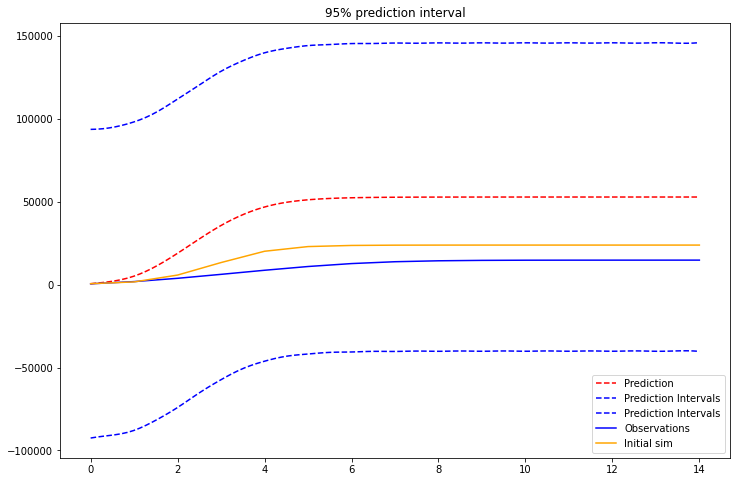

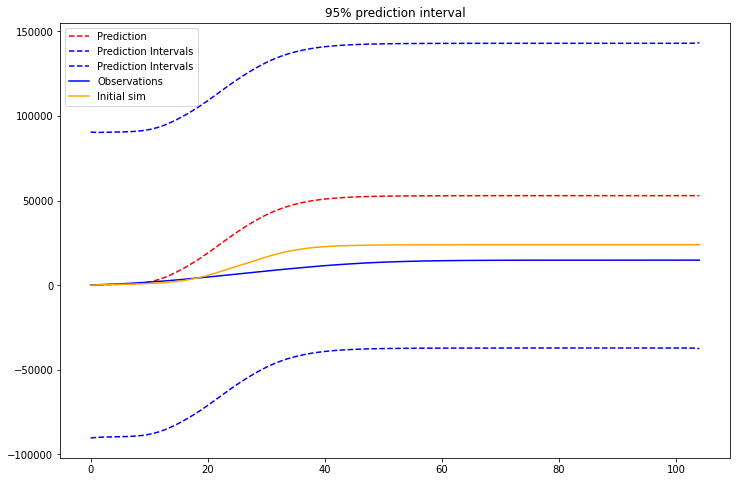

In [80]:
# Weekly

#best_paramswo long arrays with every result from every particle
x = list(range(len(sim_l[0])))  # List of iteration numbers (i.e week numbers)
X = []
for _iter in x * len(summaries_l):  # One sequence of iterations (0-14) for each particle (here there are 10 particles)
    X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
X = np.array(X)
y = []
for i in range(len(summaries_l)):
    y += list(sim_l[i])
y = np.array(y)

# Generate the GAM
gam = LinearGAM( n_splines=250)
#gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
gam.gridsearch(X, y)
#XX = gam.generate_X_grid(term=0, n=len(X))
XX = gam.generate_X_grid(term=0)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

#pdep, confi = gam.partial_dependence(term=0, width=.95)
#ax.plot(XX, pdep)
#ax.plot(XX, confi, c='r', ls='--')

ax.plot(x, obs_l[0], label="Observations", color="blue")
ax.plot(x, sim0, label="Initial sim", color="orange")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('95% prediction interval');


# ## Daily??

# #best_paramswo long arrays with every result from every particle
# x = list(range(len(sim_l[0])*7))  # List of iteration numbers (i.e week numbers)
# X = []
# for _iter in x * len(summaries_l):  # One sequence of iterations (0-14) for each particle (here there are 10 particles)
#     X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
# X = np.array(X)
# y = []
# for i in range(len(summaries_l)):
#     y +=  list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
# y = np.array(y)

# # Generate the GAM
# gam = LinearGAM( n_splines=250)
# #gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
# gam.gridsearch(X, y)
# #XX = gam.generate_X_grid(term=0, n=len(X))
# XX = gam.generate_X_grid(term=0)


# # Plot
# fig, ax = plt.subplots(1,1, figsize=(12,8))

# ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
# ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

# #pdep, confi = gam.partial_dependence(term=0, width=.95)
# #ax.plot(XX, pdep)
# #ax.plot(XX, confi, c='r', ls='--')

# ax.plot(x, cases_devon_daily['CumulativeCases'][0:105], label="Observations", color="blue")
# ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.legend()
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.set_title('95% prediction interval');



Do a KDE plot with a logarithmic colour scale.

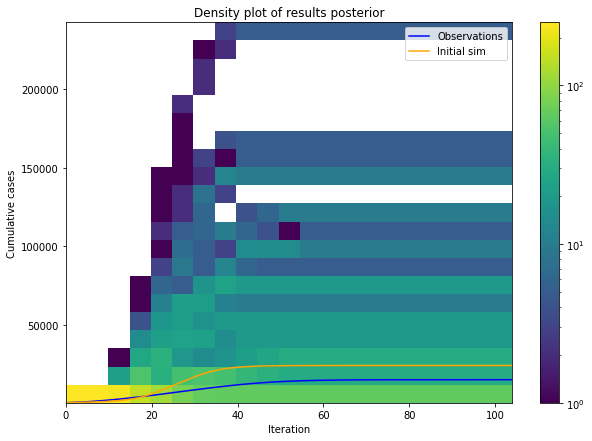

In [85]:
# # Do a KDE plot with a logarithmic colour scale.
# from matplotlib.colors import LogNorm
# fig, ax = plt.subplots(1,1, figsize=(10,7))
# h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5), norm=LogNorm())
# ax.set_xlabel("Iteration")
# ax.set_ylabel("Cumulative cases")

# ax.plot(x, obs_l[0], label="Observations", color="blue")
# ax.plot(x, sim0, label="Initial sim", color="orange")
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.legend()
# fig.colorbar(h[3], ax=ax)
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.set_title('Density plot of results posterior');


#Do a KDE plot with a logarithmic colour scale.
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,1, figsize=(10,7))
h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5), norm=LogNorm())
ax.set_xlabel("Iteration")
ax.set_ylabel("Cumulative cases")

ax.plot(x, cases_devon_daily['CumulativeCases'][0:105], label="Observations", color="blue")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
fig.colorbar(h[3], ax=ax)
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('Density plot of results posterior');

#### ABC Posterior (B) - Find the Mode(s)

_I can't work out how to find the modes (basically I think I need the largest value of the `kde`?) so instead just choose the parameter values from the best sample_

Find the 'optimal' parameters

In [86]:
####### Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
best_params


{'retail': 0.8911786782254544,
 'primary_school': 0.39622402999428064,
 'secondary_school': 0.4183087375464526,
 'work': 0.03149353460063731,
 'asymptomatic': 0.22174410669290492,
 'current_risk_beta': 0.025239665550846085}

See how those parameters relate to the marginal posteriors

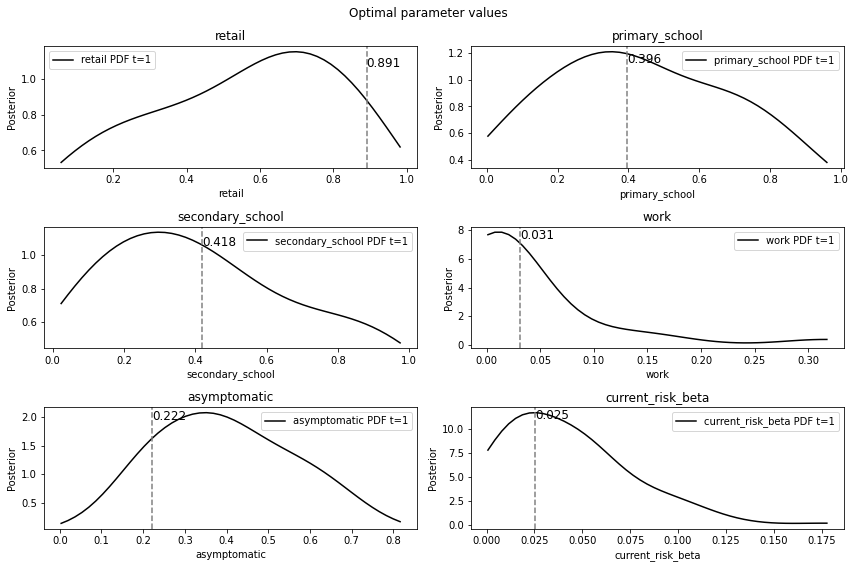

In [87]:
######## See how those parameters relate to the marginal posteriors
# fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,8))
fig, axes = plt.subplots(3,2, figsize=(12,8))

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    df, w = history.get_distribution(m=0, t=history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

Run the model with those parameters

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.89s/it]

Fitness: 5718.275663147832


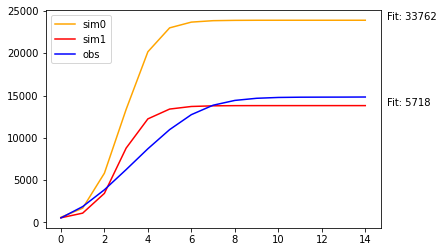

In [88]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness1, sim1, obs1, out_params1, summaries1) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly (should be same as initial, default model)
np.array_equal(obs0, obs1)

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, sim0, label="sim0", color="orange")
ax.plot(x, sim1, label="sim1", color="red")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries1, fitness1)]:
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs1, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")

Run the model with arbitray parameters (to experiment)

In [89]:
best_params

{'retail': 0.8911786782254544,
 'primary_school': 0.39622402999428064,
 'secondary_school': 0.4183087375464526,
 'work': 0.03149353460063731,
 'asymptomatic': 0.22174410669290492,
 'current_risk_beta': 0.025239665550846085}

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.83s/it]


Fitness: 5718.275663147832


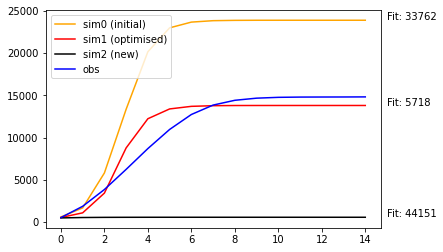

In [91]:
#OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness2, sim2, obs2, out_params2, summaries2) = OpenCLRunner.run_model_with_params_abc(
    {'retail': 0.9,
     'primary_school': 0.9,
     'secondary_school': 0.9,
     'work': 0.00001,
     'asymptomatic': 0.124},
    return_full_details=True)
#OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, sim0, label="sim0 (initial)", color="orange")
ax.plot(x, sim1, label="sim1 (optimised)", color="red")
ax.plot(x, sim2, label="sim2 (new)", color="black")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries1, fitness1), (summaries2, fitness2) ]:
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs1, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")


## Spatial analysis of the posterior

We've seen how the aggregate, cumulative disease count varies, but how do the results vary over space?



Look at the distribtion of explosed people in the optimal model

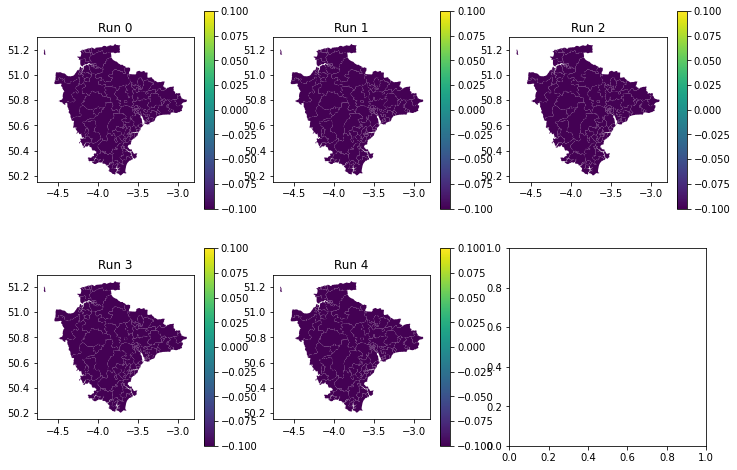

In [96]:
# Function to plot disease status by MSOA for a given timestep and status
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

## Load required data
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
gis_data_dir = ("../../devon_data")
osm_buildings = load_osm_shapefile(gis_data_dir)
devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)    
    

N=len(summaries1)
disease_status = "exposed"

fig, axes = plt.subplots(nrows=2, ncols=int(N/2) if (N % 2) == 0 else int(N/2)+1,
                    figsize=(12,8))

for i in range(N):
    #idx = indices[i]
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes, summaries1[i], disease_status, 99, ax=ax)
    ax.set_title(f"Run {i}")

XXXX HERE there is too much spatial variation? Might need to reduce impact of workplace interactions. Or maybe this is interesting. 